##Check GPU VRAM

In [2]:
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]

if gpu.memoryFree < 1000:
    raise Exception('Insufficient GPU memory: {}MB'.format(gpu.memoryFree))   
else:
    print('Free GPU RAM: {}MB'.format(gpu.memoryFree))

Free GPU RAM: 3658.0MB


##Import Packages

In [4]:
import os
import cv2
import sys
import numpy as np
import json
import random
import matplotlib.pyplot as plt
from collections import Counter
from random import choice, sample
from PIL import Image
import matplotlib.image as mpimg
from statistics import mean
import skimage.transform

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
import torch.backends.cudnn as cudnn

# %pip install wandb 
import wandb
wandb.login()

import warnings
warnings.filterwarnings('ignore')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using {device} device')

using cuda device


## Download the dataset Flickr_8k

In [7]:
%%capture
if not os.path.exists('Flickr8k_Dataset'):
    !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
    !unzip 'Flickr8k_Dataset.zip'
    !sudo rm -r 'Flickr8k_Dataset.zip'

    !wget http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip
    !unzip 'caption_datasets.zip'
    !sudo rm -r 'caption_datasets.zip'

In [8]:
# print('No. of images: {}'.format(len(os.listdir('train2014/'))))
# print('No. of images for Valid: {}'.format(len(os.listdir('val2014/'))))

## Prepare the dataset

In [8]:
data = json.load(open('dataset_flickr8k.json', 'r'))

max_len = 50                # length of padded captions
image_folder = 'Flickr8k_Dataset/'   # folder containing images
min_word_freq = 5           # words with freq less than this will labelled as <unk>
captions_per_image = 5      # every image must have 5 captions
word_freq = Counter()       # Counter object to find the freq of each word

##################################################################################################
# generate word map
for img in data['images']:
    for sentence in img['sentences']:
        # Update word frequency
        word_freq.update(sentence['tokens'])

# Remove less frequent words
words = [word for word in word_freq.keys() if word_freq[word] > min_word_freq]

## Create word map
# create a dict mapping words to int starting from 1 (0 is reserved for padding)
word_map = {word: v + 1 for v, word in enumerate(words)}
# add extra tokens to the end of the dict
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0

# dict mapping int to word
rev_word_map = {value: word for word, value in word_map.items()} 

def decode(encoded_caption):
    ''' Function to decode encoded captions '''
    caption = ''
    try:
        encoded_caption = encoded_caption.numpy()
    except:
        encoded_caption = np.array(encoded_caption)

    for item in encoded_caption:
        if rev_word_map[item] not in ['<start>', '<end>', '<unk>', '<pad>']:
            caption = caption + rev_word_map[item] + ' '
        elif rev_word_map[item] == '<pad>':
            break
    return caption  

#################################################################################################
# Split the image and caption filenames into train, val and test
train_paths = []
train_captions = []
train_word_captions = []
train_caption_lens = []

valid_paths = []
valid_captions = []
valid_word_captions = []
valid_caption_lens = []

test_paths = []
test_captions = []
test_word_captions = []
test_caption_lens = []

for img in data['images']:
    captions = []
    for sentence in img['sentences']:
        if len(sentence['tokens']) <= max_len:
            captions.append(sentence['tokens'])

    # remove 0 length captions
    if len(captions) == 0:
        continue

    # make the no. of captions per image same
    if len(captions) < captions_per_image:
        # choose randomly from captions to make the length equal captions_per_image
        captions = captions + [choice(captions) for _ in range(captions_per_image - len(captions))]
    else:
        # randomly choose captions_per_image
        captions = sample(captions, k=captions_per_image)

    # Sanity check
    assert len(captions) == captions_per_image

    # Encode and pad captions
    encoded_captions = []
    caption_lens = []
    for index, caption in enumerate(captions):
        encoded_caption = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in caption] + [ # if the word is not present in word_map, put <unk>
                           word_map['<end>']] + [word_map['<pad>']] * (max_len - len(caption))                  # padding
        encoded_captions.append(encoded_caption)

        # Find caption length (including start and stop)
        caption_len = len(caption) + 2
        caption_lens.append(caption_len)

    # full path of the image 
    path = os.path.join(image_folder, img['filename'])

    # append the image path, encoded caption and and caption length to the list
    if img['split'] in {'train', 'restval'}:
        train_paths.append(path)
        train_captions.append(encoded_captions)
        train_word_captions.append(captions)
        train_caption_lens.append(caption_lens)

    elif img['split'] in {'val'}:
        valid_paths.append(path)
        valid_captions.append(encoded_captions)
        valid_word_captions.append(captions)
        valid_caption_lens.append(caption_lens)

    elif img['split'] in {'test'}:
        test_paths.append(path)
        test_captions.append(encoded_captions)
        test_word_captions.append(captions)
        test_caption_lens.append(caption_lens)

# Sanity check
assert len(train_paths) == len(train_captions) == len(train_caption_lens) == len(train_word_captions)
assert len(valid_paths) == len(valid_captions) == len(valid_caption_lens) == len(valid_word_captions)
assert len(test_paths) == len(test_captions) == len(test_caption_lens) == len(test_word_captions)

print('Total Images: {}'.format(len(train_paths) + len(valid_paths) + len(test_paths)))

Total Images: 8000


Flickr8k_Dataset/2513260012_03d33305cf.jpg
[[2631, 2, 3, 11, 12, 3, 13, 10, 2632, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2631, 14, 15, 5, 13, 1, 24, 25, 26, 27, 28, 2632, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2631, 1, 2, 3, 4, 5, 6, 1, 7, 3, 8, 9, 10, 2632, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2631, 14, 15, 22, 23, 8, 9, 10, 2632, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2631, 14, 15, 16, 17, 18, 19, 9, 20, 21, 2632, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[['black', 'dog', 'chasing', 'brown', 'dog', 'through', 'snow'], ['two', 'dogs', 'running', 'through', 'a', 'l

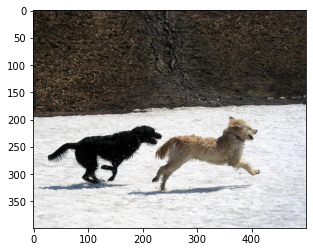

In [9]:
index = 0

print(train_paths[index])
print(train_captions[index])
print(train_word_captions[index])
print(train_caption_lens[index])

plt.imshow(mpimg.imread(train_paths[index]))

## Generate Datasets

In [10]:
class generate_dataset(Dataset):

    def __init__(self, paths, captions, caption_lens, split):
  
        self.split = split
        assert self.split in {'TRAIN', 'VAL', 'TEST'}

        self.paths = paths
        self.captions = captions
        self.caption_lens = caption_lens
        self.captions_per_image = 5

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.paths) * self.captions_per_image

    def get_image(self, i):
        img = mpimg.imread(self.paths[i // self.captions_per_image])

        # convert grayscale to RGB format
        if len(img.shape) == 2:
            img = img[:, :, np.newaxis]
            img = np.concatenate([img, img, img], axis=2)
        img = cv2.resize(img, (336, 336))

        # sanity checks
        assert img.shape == (336, 336, 3)
        assert np.max(img) <= 255
        return img

    def __getitem__(self, i):

        # Remember, the ith caption belongs to the (i // captions_per_image)th image
        img = mpimg.imread(self.paths[i // self.captions_per_image])

        # convert grayscale to RGB format
        if len(img.shape) == 2:
            img = img[:, :, np.newaxis]
            img = np.concatenate([img, img, img], axis=2)
        img = cv2.resize(img, (256, 256))

        # sanity checks
        assert img.shape == (256, 256, 3)
        assert np.max(img) <= 255

        img = self.transform(img)

        caption = torch.LongTensor(self.captions[i // self.captions_per_image][i % self.captions_per_image])

        caption_len = torch.LongTensor([self.caption_lens[i // self.captions_per_image][i % self.captions_per_image]])

        if self.split is 'TRAIN':
            return img, caption, caption_len
        else:
            # For validation of testing, also return all 'captions_per_image' captions to find BLEU-4 score
            captions = torch.LongTensor(self.captions[i // self.captions_per_image])
            return img, caption, caption_len, captions

train_dataset = generate_dataset(train_paths, train_captions, train_caption_lens, 'TRAIN')
valid_dataset = generate_dataset(valid_paths, valid_captions, valid_caption_lens, 'VAL')
test_dataset = generate_dataset(test_paths, test_captions, test_caption_lens, 'TEST')

### Visualize train dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([52])
torch.Size([1]) 

black dog chasing brown dog through snow 
Length: 9 



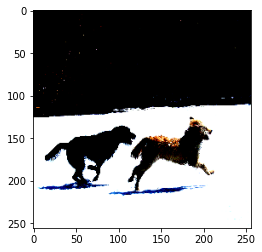

In [11]:
img, caption, caption_len  = train_dataset[0] 

print(img.shape)
print(caption.shape)
print(caption_len.shape, '\n')

print(decode(caption))
print('Length: {}'.format(caption_len.item()), '\n')

plt.imshow(img.numpy().transpose(1,2,0))

### Visualize valid dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([52])
torch.Size([5, 52])
torch.Size([1]) 

two people play on a long skateboard 
the boy laying face down on a skateboard is being pushed along the ground by another boy 
two young children on a skateboard going across a sidewalk 
two girls play on a skateboard in a courtyard 
two small children in red shirts playing on a skateboard 

Length: 11 



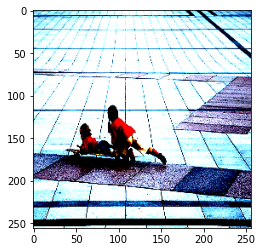

In [12]:
img, caption, caption_len, captions  = valid_dataset[3] 

print(img.shape)
print(caption.shape)
print(captions.shape)
print(caption_len.shape, '\n')

for cap in captions:
    print(decode(cap))

print('\nLength: {}'.format(caption_len.item()), '\n')

plt.imshow(img.numpy().transpose(1,2,0))

### Visualize test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([52])
torch.Size([5, 52])
torch.Size([1]) 

the small brown and white dog is in the pool 
a dog swims in a pool near a person 
a brown and white dog swimming towards some in the pool 
small dog is paddling through the water in a pool 
a dog in a swimming pool swims toward see 

Length: 12 



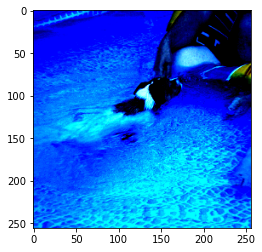

In [13]:
img, caption, caption_len, captions  = test_dataset[8] 

print(img.shape)
print(caption.shape)
print(captions.shape)
print(caption_len.shape, '\n')

for cap in captions:
    print(decode(cap))

print('\nLength: {}'.format(caption_len.item()), '\n')

plt.imshow(img.numpy().transpose(1,2,0))

## Generate Dataloaders

In [14]:
print("Train Images: {}".format(len(train_dataset)))
print("Valid Images: {}".format(len(valid_dataset)))
print("Test Images:  {}".format(len(test_dataset)),'\n')

batch_size = 2

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

images, captions, caption_lens = next(iter(train_loader))
print(images.shape)
print(captions.shape)
print(caption_lens.shape)

Train Images: 30000
Valid Images: 5000
Test Images:  5000 

torch.Size([2, 3, 256, 256])
torch.Size([2, 52])
torch.Size([2, 1])


## Network

In [15]:
class Encoder(nn.Module):

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()

        self.enc_image_size = encoded_image_size

        # pretrained ImageNet ResNet-101
        resnet = torchvision.models.resnet101(pretrained=True)  

        # Remove linear and pool layers 
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image using adaptive avg pool to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        self.fine_tune()

    def forward(self, images):
        """
        :param images: images, a tensor of dim (batch_size, 3, image_size, image_size)
        :return: encoded images, a tensor of dim (batch_size, encoded_image_size, encoded_image_size, 2048)
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        return out

    def fine_tune(self, fine_tune=False):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.
        :param fine_tune: Boolean
        """
        for param in self.resnet.parameters():
            param.requires_grad = False
        # If fine-tuning, fine-tune convolutional blocks 2 through 4
        for child in list(self.resnet.children())[5:]:
            for param in child.parameters():
                param.requires_grad = fine_tune

class Attention(nn.Module):

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoder's output
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights for weighted avg (attention )

    def forward(self, encoder_out, decoder_hidden):
        """
        :param encoder_out: encoder's output, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights (attention)
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1)))  # (batch_size, num_pixels, 1)
        alpha = self.softmax(att)  # (batch_size, num_pixels, 1)
        attention_weighted_encoding = (encoder_out * alpha).sum(dim=1)  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha.squeeze(2)  # (batch_size, encoder_dim), (batch_size, num_pixels)


class DecoderWithAttention(nn.Module):

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: feature size of decoder's RNN output
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size

        # attention network
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(0.5)

        # lstm cell takes prev word output (embed_dim) and also the weighted encoded image (encoder_dim)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        :param encoder_out: encoded images (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)   # (batch_size, encoder_dim)

        h = self.init_h(mean_encoder_out)            # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)            # (batch_size, decoder_dim)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lens):
        """
        Forward propagation.
        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lens: caption lengths, a tensor of dimension (batch_size, 1)
        """

        batch_size = encoder_out.size(0)

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, self.encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort the encoded image, caption and length by decreasing caption length
        caption_lens, sort_index = caption_lens.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_index]
        encoded_captions = encoded_captions[sort_index]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are caption lengths - 1
        decode_lens = (caption_lens - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lens), self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lens), num_pixels).to(device)

        # At each time-step, decode by attention-weighing the encoder's output 
        # based on the decoder's previous hidden state output then generate a 
        # new word in the decoder with the previous word and the attention weighted encoding.
        for t in range(max(decode_lens)):
            # For each time step the batch size changes
            batch_size_t = sum([l > t for l in decode_lens])

            # get attention weighted encodings (batch_size_t, encoder_dim)
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])

            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # sigmoid activated gate (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding

            # decoder input is formed from the embeddings of the current (t) word and the attention weighted encoding
            decoder_input = torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1)
            h, c = self.decode_step(decoder_input, (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)

            # next word prediction for current word
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)

            # save the prediction and alphas at every time step (t)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lens, alphas, sort_index

## Loss Function

In [16]:
def custom_loss(scores, targets, criterion, alphas):
    # Add doubly stochastic attention regularization along with CE loss
    # Forces the model to attend to every pixel over the course of generating the entire sequence
    loss = criterion(scores, targets) + ((1. - alphas.sum(dim=1)) ** 2).mean()
    return loss

## Helper function to train and validate

In [17]:
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

def print_overwrite(step, total_step, loss, acc, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f  Accuracy: %.4f" % (step, total_step, loss, acc))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f  Accuracy: %.4f" % (step, total_step, loss, acc))
    sys.stdout.flush()

def save_checkpoint(epoch, encoder, decoder, encoder_optimizer, decoder_optimizer, bleu4):
    global best_bleu4

    state_dict = {'epoch': epoch,
                  'bleu-4': bleu4,
                  'encoder': encoder,
                  'decoder': decoder,
                  'encoder_optimizer': encoder_optimizer,
                  'decoder_optimizer': decoder_optimizer}

    filename = 'image_captioning.pth'
    torch.save(state_dict, filename)

    # If there is an improvement in BLUE-4 score, save checkpoint
    if bleu4 > best_bleu4:
        best_bleu4 = bleu4
        print("Max BLEU-4 Score: {:.4f}\n".format(best_bleu4))
        filename = 'image_captioning_best.pth'
        torch.save(state_dict, filename)
        

def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    """
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

def log_performance(epoch, loss_train, acc_train, loss_valid, acc_valid, bleu4_valid, best_bleu4, encoder_lr_scheduler, decoder_lr_scheduler):
    if encoder_lr_scheduler is not None:
        wandb.log({
            "Epoch": epoch,
            "Train Loss": loss_train,
            "Train Acc": acc_train,
            "Valid Loss": loss_valid,
            "Valid Acc": acc_valid,
            "BLEU-4": bleu4_valid,
            "Max BLEU-4": best_bleu4,
            "Encoder LR": encoder_lr_scheduler.state_dict()['_last_lr'][0],
            "Decoder LR": decoder_lr_scheduler.state_dict()['_last_lr'][0]})
    else:
        wandb.log({
            "Epoch": epoch,
            "Train Loss": loss_train,
            "Train Acc": acc_train,
            "Valid Loss": loss_valid,
            "Valid Acc": acc_valid,
            "BLEU-4": bleu4_valid,
            "Max BLEU-4": best_bleu4,
            "Encoder LR": 0,
            "Decoder LR": decoder_lr_scheduler.state_dict()['_last_lr'][0]})

In [18]:
def train(encoder, decoder, criterion, encoder_optimizer, decoder_optimizer):
    loss = []
    acc = []

    # train mode (dropout and batchnorm is used)
    decoder.train()  
    encoder.train()

    for step, (imgs, caps, caplens) in enumerate(train_loader):

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove the pads
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

        # Calculate loss
        loss_step = custom_loss(scores, targets, criterion, alphas)
        loss.append(loss_step.item())

        # Calculate top k accuracy
        acc_step = accuracy(scores, targets, 5)
        acc.append(acc_step) 

        print_overwrite(step, len(train_loader), loss_step, acc_step, 'train')

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss_step.backward()

        # Clip gradients
        clip_gradient(decoder_optimizer, grad_clip = 5)
        if encoder_optimizer is not None:
            clip_gradient(encoder_optimizer, grad_clip = 5)

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()
    return mean(loss), mean(acc)

def validate(encoder, decoder, criterion):
    loss = []
    acc = []
    
    # eval mode (no dropout or batchnorm)
    decoder.eval()  
    encoder.eval()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # explicitly disable gradient calculation to avoid CUDA memory error
    with torch.no_grad():
        # Batches
        for step, (imgs, caps, caplens, allcaps) in enumerate(valid_loader):

            # Move to device, if available
            imgs = imgs.to(device)
            caps = caps.to(device)
            caplens = caplens.to(device)
            allcaps = allcaps.to(device)

            # Forward prop.
            imgs = encoder(imgs)
            scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

            # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
            targets = caps_sorted[:, 1:]

            # Remove the pads
            scores_copy = scores.clone()
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True).data
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True).data

            # Calculate loss
            loss_step = custom_loss(scores, targets, criterion, alphas)
            loss.append(loss_step.item())

            # Calculate top k accuracy
            acc_step = accuracy(scores, targets, 5)
            acc.append(acc_step) 

            print_overwrite(step, len(valid_loader), loss_step, acc_step, 'valid')

            # Store references (true captions), and hypothesis (prediction) for each image
            # If for n images, we have n hypotheses, and n references a, b, c... for each image,
            # references = [[ref1a, ref1b,.., ref1e], [ref2a, ref2b,.., ref2e], ...], hypotheses = [hyp1, hyp2, ...]
            # references will have all the captions (after <start> to <end>) for the images in the batch 
            # hypotheses will have the captions generated by the network, the network might not generate the last word as <end>

            # References
            allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
            for i in range(allcaps.shape[0]):
                img_caps = allcaps[i].tolist()
                img_captions = list(map(lambda caption: [word for word in caption if word not in {word_map['<start>'], word_map['<pad>']}], img_caps))  # remove <start> and pads
                references.append(img_captions)

            # Hypotheses
            preds = torch.argmax(scores_copy, dim=2).tolist()
            temp_preds = list()
            for i, pred in enumerate(preds):
                temp_preds.append(pred[:decode_lengths[i]])  # remove pads
            hypotheses.extend(temp_preds)

            # sanity check
            assert len(references) == len(hypotheses)
            
        # Calculate BLEU-4 scores
        bleu4 = corpus_bleu(references, hypotheses)
    return mean(loss), mean(acc), bleu4

## Training Loop

In [20]:
# Model parameters
embed_dim = 512      # dimension of word embeddings
attention_dim = 512  # dimension of attention linear layers
decoder_dim = 512    # dimension of decoder RNN
encoder_dim = 2048
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder
vocab_size = len(word_map)
lr_decay_factor = 0.8
lr_decay_patience = 8
best_bleu4 = 0

start_epoch = 1
num_epochs = 11
                                           
fine_tune_encoder = False  # fine-tune encoder?
checkpoint =  None # 'image_captioning.pth'  # image_captioning_best.pth
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if checkpoint is None:
    wandb.init(name='Image Captioning', entity="advaitshah93", project="Personal")

#######################################################################################################################
# Checkpoint
if checkpoint is None:
    decoder = DecoderWithAttention(attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim)
    decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()), lr=decoder_lr)

    encoder = Encoder()
    encoder.fine_tune(fine_tune_encoder)
    encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()), lr=encoder_lr) if fine_tune_encoder else None

else:
    checkpoint = torch.load(checkpoint)

    start_epoch = checkpoint['epoch'] + 1
    best_bleu4 = checkpoint['bleu-4']
    encoder = checkpoint['encoder']
    decoder = checkpoint['decoder']
    encoder_optimizer = checkpoint['encoder_optimizer']
    decoder_optimizer = checkpoint['decoder_optimizer']

    if fine_tune_encoder is True and encoder_optimizer is None:
        encoder.fine_tune(fine_tune_encoder)
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()), lr=encoder_lr)

decoder = decoder.to(device)
encoder = encoder.to(device)

# Learning Rate Scheduler
decoder_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, mode='max', factor=lr_decay_factor, patience=lr_decay_patience)
encoder_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, mode='max', factor=lr_decay_factor, patience=lr_decay_patience) if fine_tune_encoder else None

# CE Loss function
criterion = nn.CrossEntropyLoss().to(device)

# Loop
for epoch in range(start_epoch, num_epochs):

    loss_train, acc_train = train(encoder, decoder, criterion, encoder_optimizer, decoder_optimizer)
    loss_valid, acc_valid, bleu4_valid = validate(encoder, decoder, criterion)

    # Reduce the learning rate on Plateau
    decoder_lr_scheduler.step(bleu4_valid)
    if fine_tune_encoder:
        encoder_lr_scheduler.step(bleu4_valid)

    # log the performance to wandb
    log_performance(epoch, loss_train, acc_train, loss_valid, acc_valid, bleu4_valid, best_bleu4, encoder_lr_scheduler, decoder_lr_scheduler)
    
    print('\n--------------------------------------------------------------------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.2f} %  Valid Loss: {:.4f}  Valid Acc: {:.2f} %  Best BLEU-4: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid, best_bleu4))
    print('--------------------------------------------------------------------------------------------------------------')

    save_checkpoint(epoch, encoder, decoder, encoder_optimizer, decoder_optimizer, bleu4_valid)

Valid Steps: 2499/2500  Loss: 3.3763  Accuracy: 66.6667000
--------------------------------------------------------------------------------------------------------------
Epoch: 1  Train Loss: 4.6358  Train Acc: 55.82 %  Valid Loss: 4.2436  Valid Acc: 61.24 %  Best BLEU-4: 0.0000
--------------------------------------------------------------------------------------------------------------
Max BLEU-4 Score: 0.0936

Valid Steps: 2499/2500  Loss: 3.9548  Accuracy: 61.1111520
--------------------------------------------------------------------------------------------------------------
Epoch: 2  Train Loss: 4.1483  Train Acc: 62.48 %  Valid Loss: 4.0688  Valid Acc: 63.78 %  Best BLEU-4: 0.0936
--------------------------------------------------------------------------------------------------------------
Max BLEU-4 Score: 0.0999

Valid Steps: 2499/2500  Loss: 3.6284  Accuracy: 81.2500570
-----------------------------------------------------------------------------------------------------------

## Download pretrained weights

In [19]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load('image_captioning_best.pth', map_location=device)

encoder = checkpoint['encoder']
decoder = checkpoint['decoder']


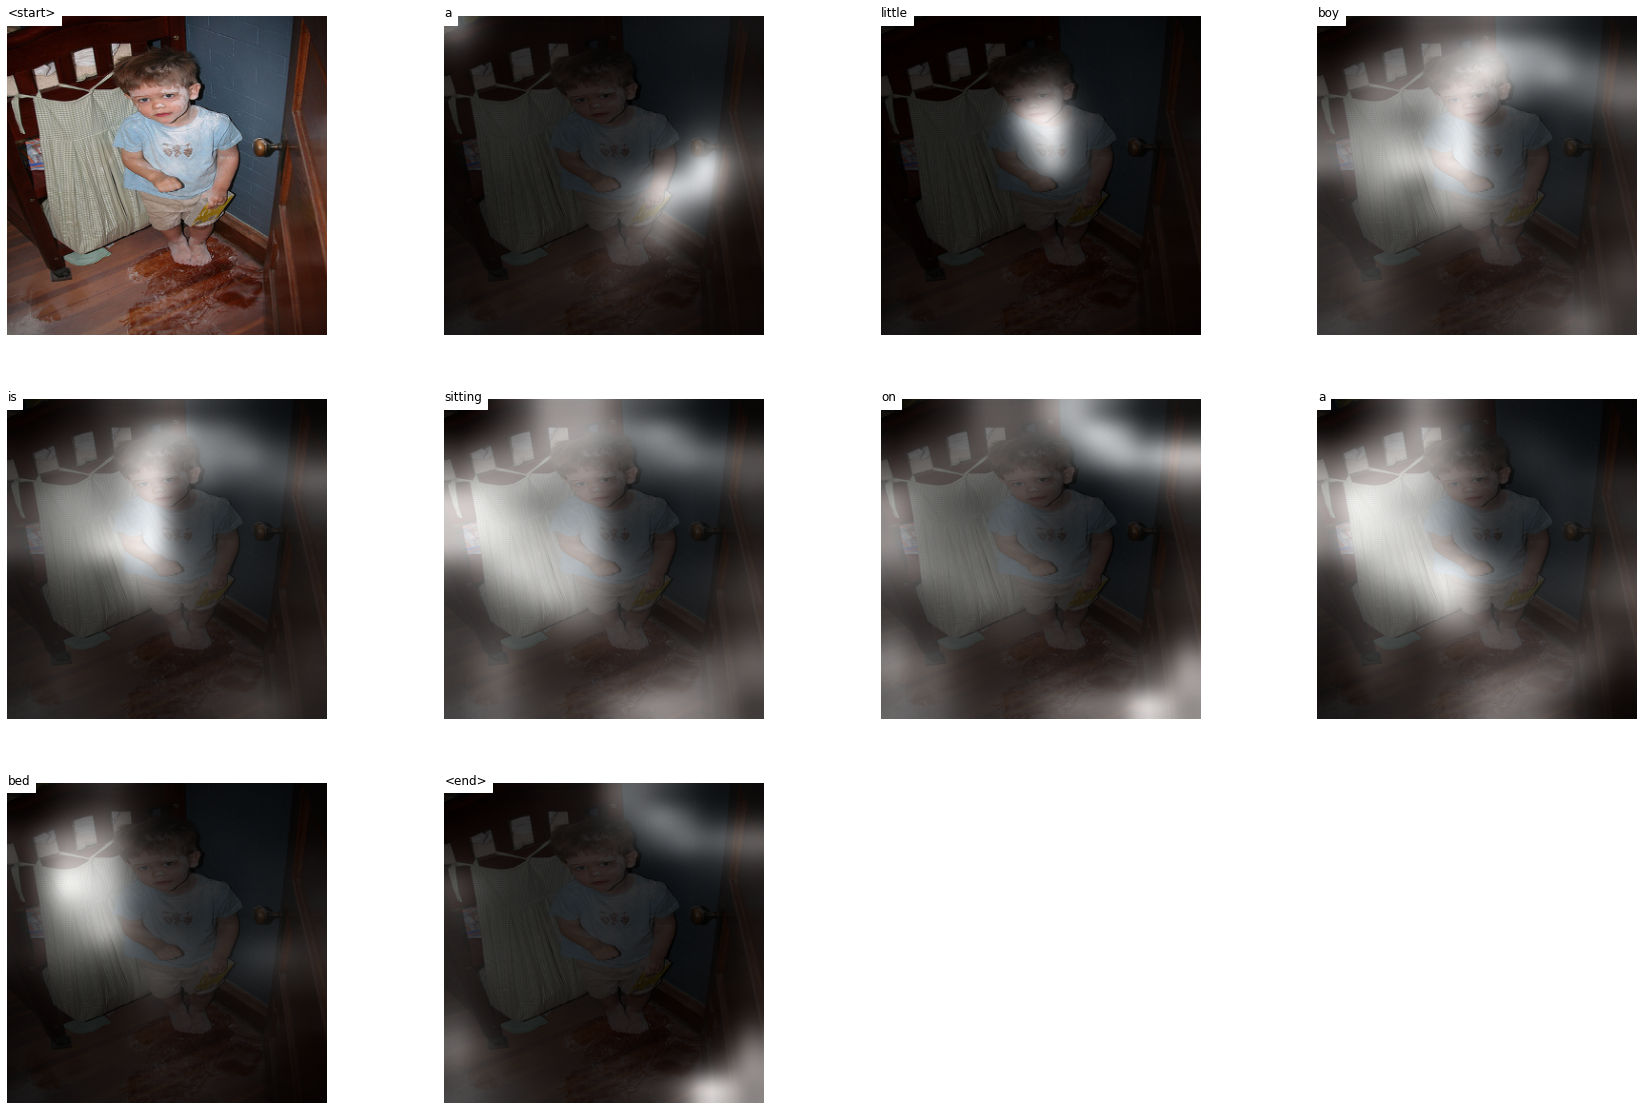

In [35]:
# Sample a test image and caption it
def caption_test_data(encoder, decoder, word_map, beam_size=7):
    """
    Randomly samples the test dataset and plots attention
    along with the caption.
    """

    k = beam_size

    # dict mapping int to word
    rev_word_map = {value: word for word, value in word_map.items()} 

    idx = random.randint(0, 500)  # randomly sample the test dataset
    image, _, _, _ = test_dataset[idx] # (1, 3, 256, 256)
    image = image.to(device)
    encoder_out = encoder(image.unsqueeze(0))  # (1, enc_image_size, enc_image_size, encoder_dim)
    
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoded image
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    top_k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    top_k_seqs = top_k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    top_k_seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    # initially s will be k, s will eventually get reduced to 0
    while True:

        embeddings = decoder.embedding(top_k_prev_words).squeeze(1)  # (s, embed_dim)

        attention_weighted_encoding, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels, 1)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        attention_weighted_encoding = gate * attention_weighted_encoding

        h, c = decoder.decode_step(torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add the current scores to the prev scores
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        # Considering only the first sequence as all the scores are alike
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words // vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        top_k_seqs = torch.cat([top_k_seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        top_k_seqs_alpha = torch.cat([top_k_seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)], dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(top_k_seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(top_k_seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break

        top_k_seqs = top_k_seqs[incomplete_inds]
        top_k_seqs_alpha = top_k_seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        top_k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    # select the sequence with maximum score
    index = complete_seqs_scores.index(max(complete_seqs_scores))
    sequence = complete_seqs[index]
    alphas = complete_seqs_alpha[index]
    caption = [rev_word_map[index] for index in sequence]

    # Plot the image and attention
    plt.figure(figsize=(30,20))
    for word in range(len(caption)):   # +2 for <start> and <end>
        # Plot the image
        plt.subplot(np.ceil(len(caption) / 4), 4, word + 1)
        plt.text(0, 1, '%s' % (caption[word]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(test_dataset.get_image(idx))

        # Plot the attention
        current_alpha = alphas[word]
        alpha = skimage.transform.pyramid_expand(current_alpha, upscale=24, sigma=8)
        if word == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap('gray')
        plt.axis('off')
    plt.show()

vocab_size = len(word_map)

caption_test_data(encoder, decoder, word_map, beam_size=7)

In [21]:
# Caption custom images
# Enter the URL of any image.

def caption_custom_data(encoder, decoder, word_map, beam_size=7):
    """
    For the given image, plots attention along with the caption.
    """

    k = beam_size

    # dict mapping int to word
    rev_word_map = {value: word for word, value in word_map.items()} 

    # Read the image
    image_array = np.array(Image.open('pic.png'))
    # convert grayscale to RGB format
    if len(image_array.shape) == 2:
        image_array = image_array[:, :, np.newaxis]
        image_array = np.concatenate([image_array, image_array, image_array], axis=2)
    image_array = cv2.resize(image_array, (336, 336))

    # sanity checks
    assert image_array.shape == (336, 336, 3)
    assert np.max(image_array) <= 255

    convert_to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    image = (normalize(convert_to_tensor(image_array)))
    image = image.to(device)
    encoder_out = encoder(image.unsqueeze(0))  # (1, enc_image_size, enc_image_size, encoder_dim)
    
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoded image
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    top_k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    top_k_seqs = top_k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    top_k_seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    # initially s will be k, s will eventually get reduced to 0
    while True:

        embeddings = decoder.embedding(top_k_prev_words).squeeze(1)  # (s, embed_dim)

        attention_weighted_encoding, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels, 1)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        attention_weighted_encoding = gate * attention_weighted_encoding

        h, c = decoder.decode_step(torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add the current scores to the prev scores
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        # Considering only the first sequence as all the scores are alike
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words // vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        top_k_seqs = torch.cat([top_k_seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        top_k_seqs_alpha = torch.cat([top_k_seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)], dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(top_k_seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(top_k_seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break

        top_k_seqs = top_k_seqs[incomplete_inds]
        top_k_seqs_alpha = top_k_seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        top_k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    # select the sequence with maximum score
    index = complete_seqs_scores.index(max(complete_seqs_scores))
    sequence = complete_seqs[index]
    alphas = complete_seqs_alpha[index]
    caption = [rev_word_map[index] for index in sequence]

    # Plot the image and attention
    plt.figure(figsize=(30,20))
    for word in range(len(caption)):   # +2 for <start> and <end>
        # Plot the image
        plt.subplot(np.ceil(len(caption) / 4), 4, word + 1)
        plt.text(0, 1, '%s' % (caption[word]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image_array)

        # Plot the attention
        current_alpha = alphas[word]
        alpha = skimage.transform.pyramid_expand(current_alpha, upscale=24, sigma=8)
        if word == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap('gray')
        plt.axis('off')
    plt.show()


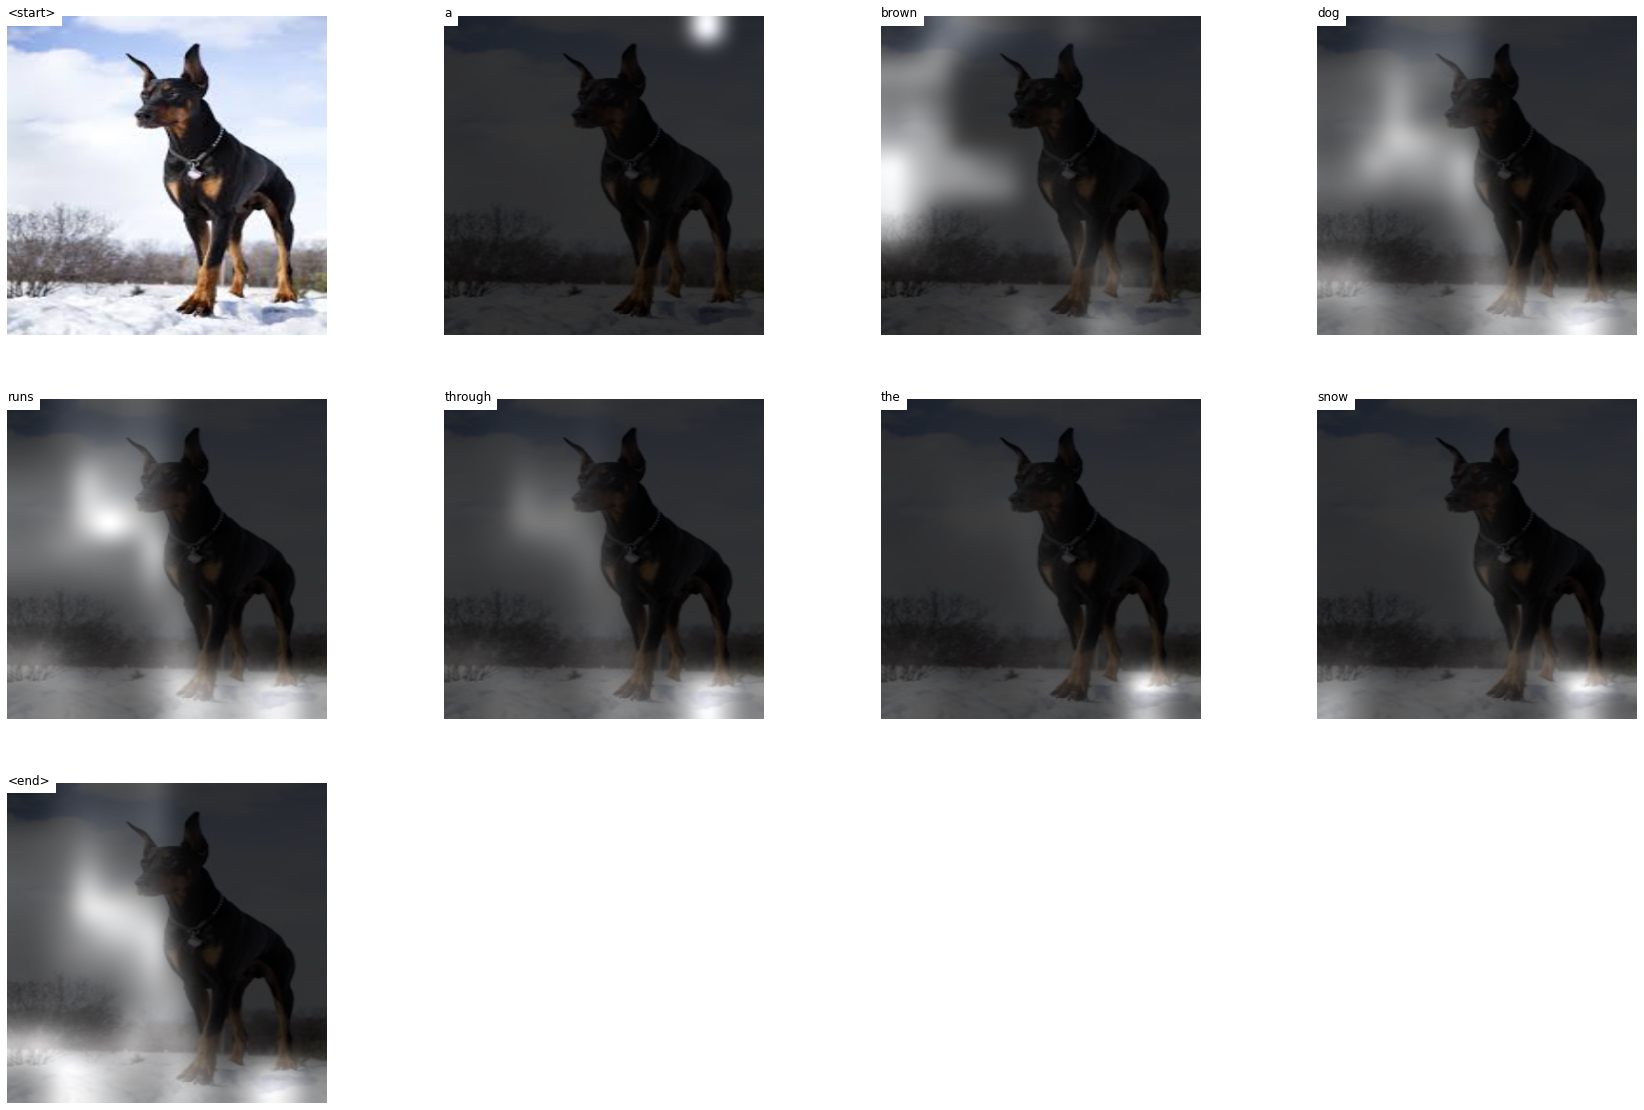

In [27]:
URL = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTrgJ3nTaYYi_wjoVcWdoh4bPrSzbLp9zQFrA&usqp=CAU' 

Beam_Size = 7 

from urllib.request import urlretrieve
urlretrieve(URL,'pic.png')
caption_custom_data(encoder, decoder, word_map, Beam_Size)